In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [2]:
btc = web.DataReader('BTC-USD', data_source='yahoo', start='01-01-2017')
btc.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-06,15903.437500,15226.839844,15579.729492,15565.880859,39837841971,15565.880859
2020-11-07,15737.095703,14423.203125,15565.880859,14833.753906,35024953705,14833.753906
2020-11-08,15637.320312,14744.110352,14833.753906,15479.567383,26632075028,15479.567383
2020-11-09,15785.136719,14865.529297,15479.595703,15332.315430,34149115565,15332.315430
2020-11-10,15450.329102,15128.057617,15387.036133,15160.738281,30946164736,15160.738281


In [3]:
lows=btc['Low']
highs=btc['High']

In [5]:
btc_signal = pd.DataFrame(index=btc.index)
btc_signal['price'] = btc['Adj Close']

# S/R Technical Trading Strategy

Parameters for Code 
- The minimum number of times that BTC price has to reach the S/R level.
- Defining the tolerance margin of is considered being close to the S/R level.

Following rules apply this trading strategy: 
- trading_support_resistance function defines the time window in the BTC price that is used to calculate the S/R levels.
- The level of S/R is calculated by taking the maximum and minimum price and then subtracting and adding a defined 20% margin
- Using the .diff() feature to know when to Buy or Sell.  
- When the price is below/above the S/R, will enter a long/short position. 

In [6]:
def trading_support_resistance(data, bin_width=20): 
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data))) 
    data['sup'] = pd.Series(np.zeros(len(data))) 
    data['res'] = pd.Series(np.zeros(len(data))) 
    data['positions'] = pd.Series(np.zeros(len(data))) 
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
    
    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1] 
        support_level=min(data_section['price']) 
        resistance_level=max(data_section['price']) 
        range_level=resistance_level-support_level 
        data['res'][x]=resistance_level
        data['sup'][x]=support_level 
        data['sup_tolerance'][x]=support_level + 0.2 * range_level 
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
        
        if data['price'][x]>=data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        
        if in_resistance>1:
            data['signal'][x]=1
        elif in_support>1:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
    
    data['positions']=data['signal'].diff()

trading_support_resistance(btc_signal)

In [7]:
btc_signal['price'].rolling(window=20).mean()

Date
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04             NaN
2017-01-05             NaN
2017-01-06             NaN
2017-01-07             NaN
2017-01-08             NaN
2017-01-09             NaN
2017-01-10             NaN
2017-01-11             NaN
2017-01-12             NaN
2017-01-13             NaN
2017-01-14             NaN
2017-01-15             NaN
2017-01-16             NaN
2017-01-17             NaN
2017-01-18             NaN
2017-01-19             NaN
2017-01-20      911.574545
2017-01-21      907.747745
2017-01-22      902.893893
2017-01-23      896.752496
2017-01-24      883.650348
2017-01-25      878.058447
2017-01-26      878.827698
2017-01-27      879.385947
2017-01-28      879.905499
2017-01-29      880.738898
2017-01-30      881.374048
                  ...     
2020-10-11    10818.128027
2020-10-12    10878.129785
2020-10-13    10912.327686
2020-10-14    10951.980664
2020-10-15    10980.364941
2020-10-16    11009.548

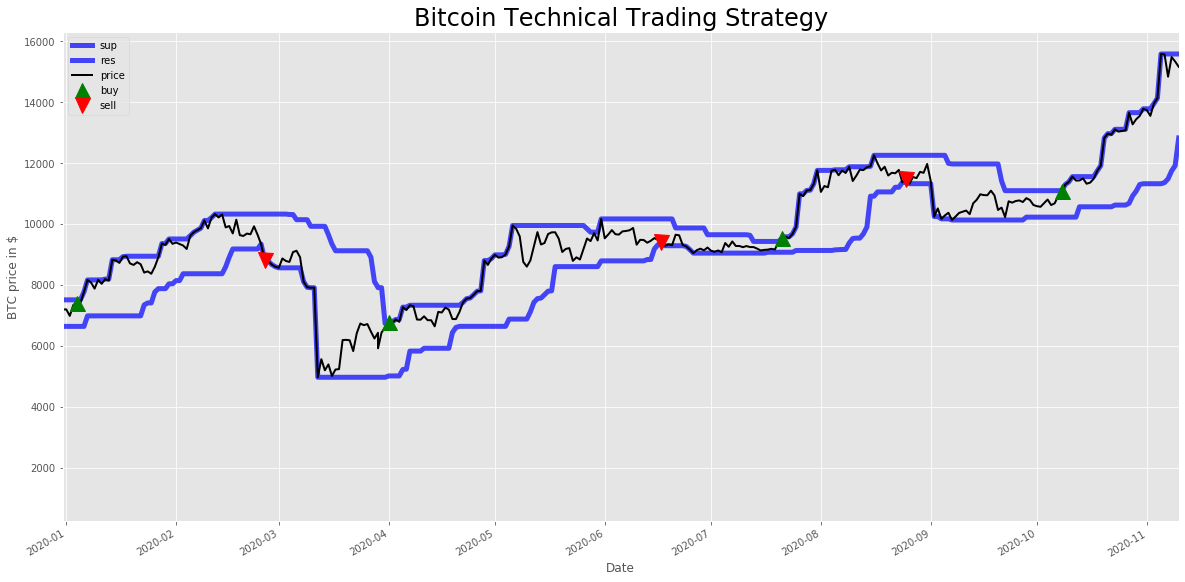

In [8]:
# Plotting the Strategy performance 2020 
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111, ylabel='BTC price in $') 
btc_signal['sup'].loc['2019-12-31':].plot(ax=ax1, color='b', lw=5, alpha =.7) 
btc_signal['res'].loc['2019-12-31':].plot(ax=ax1, color='b', lw=5, alpha =.7)
btc_signal['price'].loc['2019-12-31':].plot(ax=ax1, color='k', lw=2.)

ax1.plot(btc_signal.loc[btc_signal.positions == 1.0].index, btc_signal.price[btc_signal.positions == 1.0],
         '^', markersize = 15, color = 'green', label='buy')

ax1.plot(btc_signal.loc[btc_signal.positions == -1.0].index, btc_signal.price[btc_signal.positions == -1.0],
         'v', markersize = 15, color = 'red', label='sell')

plt.title('Bitcoin Technical Trading Strategy', fontsize= 24)
plt.legend()
plt.show()

# Data Viz: 

The plot shows a 20-day rolling window calculating resistance and support:
- it is observed that a buy order is sent when a price stays in the resistance tolerance margin for 1 consecutive days, and that a sell order is sent when a price stays in the support tolerance margin for 1 consecutive days.


In [25]:
btc_last_year = btc_signal.loc['12-31-2019':]
btc_last_year.head() # positions long = 1 position = sell/short = -1 

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2019-12-31,7193.599121,6814.729883,7337.374121,NaN,NaN,6640.515137,7511.588867,0.0,0.0
2020-01-01,7200.174316,6814.729883,7337.374121,NaN,NaN,6640.515137,7511.588867,0.0,0.0
2020-01-02,6985.470215,6814.729883,7337.374121,NaN,NaN,6640.515137,7511.588867,0.0,0.0
2020-01-03,7344.884277,6814.729883,7337.374121,NaN,1.0,6640.515137,7511.588867,0.0,0.0
2020-01-04,7410.656738,6814.729883,7337.374121,NaN,2.0,6640.515137,7511.588867,1.0,1.0


In [59]:
btc_signal1 = btc_signal.loc['2020-01-04':'2020-02-26']
# 20% returns

In [70]:
print(btc_signal1['price'].pct_change().sum() * 100)

19.437870921495225


In [72]:
btc_signal2 = btc_signal.loc['2020-04-01':'2020-06-20'] #6793 start end at 9410
print(btc_signal2['price'].pct_change().sum() * 100) 

35.737175382970484


In [76]:
btc_signal3 = btc_signal.loc['2020-07-21':'2020-08-25']
print(btc_signal3['price'].pct_change().sum() * 100)

20.1068636482023


In [77]:
btc_signal4 = btc_signal.loc['2020-10-08':]
print(btc_signal4['price'].pct_change().sum() * 100)

30.21226713276911


In [80]:
# Backtesting strategy

In [87]:
initial_capital = float(5000.0)

In [88]:
# Now, we will create a data frame for the positions and the portfolio:
positions = pd.DataFrame(index=btc_last_year.index).fillna(0.0)
portfolio = pd.DataFrame(index=btc_last_year.index).fillna(0.0)

In [89]:
# Next, we will store the BTC positions in the following data frame:
positions['BTC'] = btc_last_year['signal']

In [90]:
#Then, we will store the amount of the BTC positions for the portfolio in this one:

portfolio['positions'] = (positions.multiply(btc_last_year['price'], axis=0))

In [91]:
#Next, we will calculate the non-invested money (cash):
portfolio['cash'] = initial_capital - (positions.diff().multiply(btc_last_year['price'], axis=0)).cumsum()

In [92]:
# The total investment will be calculated by summing the positions and the cash:

portfolio['total'] = portfolio['positions'] + portfolio['cash']

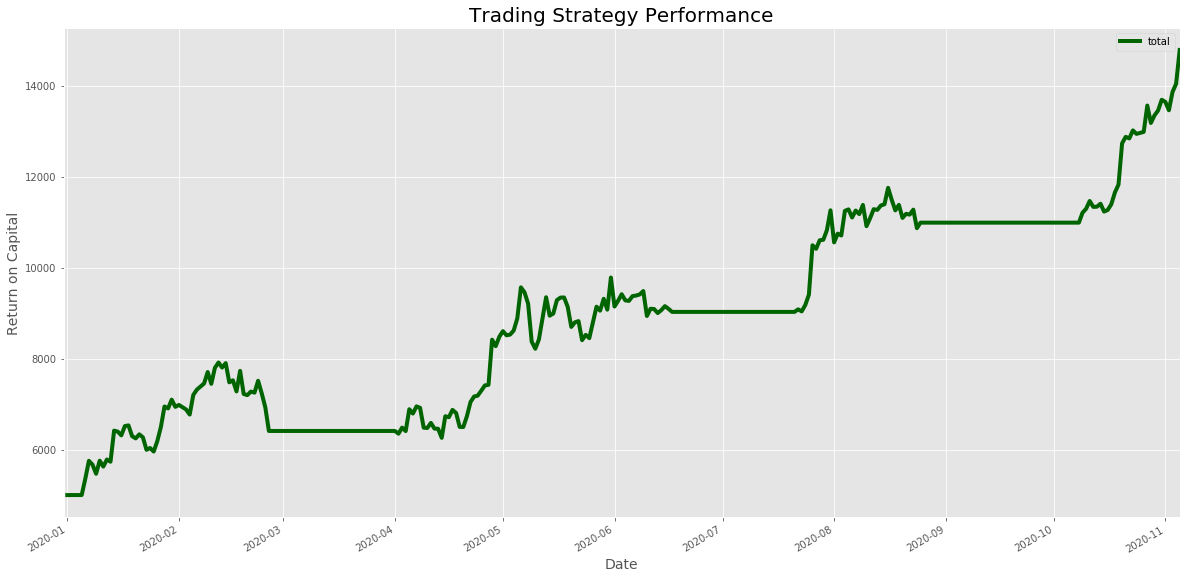

In [104]:
# When we draw the following plot, we can easily establish that our strategy is profitable:

f,ax= plt.subplots(figsize=(20,10))

portfolio['total'].plot(c='darkgreen', lw=4)
ax.set_title('Trading Strategy Performance', fontsize = 20)
ax.set_ylabel('Return on Capital', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)

ax.legend()